<a href="https://colab.research.google.com/github/VishwathRam/Basic-Blog/blob/main/multiclass_unet_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2

W = 1024 
H = 64

def process_data(data_path, file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    names = df[0].values

    images = [os.path.join(data_path, f"/content/drive/MyDrive/Projects/Lincoln_unet/input1/train/{name}.jpg") for name in names]
    masks = [os.path.join(data_path, f"/content/drive/MyDrive/Projects/Lincoln_unet/input1/mask/{name}.tif") for name in names]

    return images, masks

def load_data(path):
    train_valid_path = os.path.join(path, "/content/drive/MyDrive/Projects/Lincoln_unet/input1/trainval.txt")
    test_path = os.path.join(path, "/content/drive/MyDrive/Projects/Lincoln_unet/input1/test.txt")

    train_x, train_y = process_data(path, train_valid_path)
    test_x, test_y = process_data(path, test_path)

    train_x, valid_x = train_test_split(train_x, test_size=0.1, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=0.1, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    # x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    # x = cv2.resize(x, (W, H))
    # x = x - 1
    # x = x.astype(np.int32)
    # return x
    BGR_classes = {'a' : [ 0, 0, 0],
                   'b' : [255,  255, 255],
                   'c' : [36, 28, 237]} # in RGB #237,28,36

    bin_classes = ['a', 'b', 'c']
    mask = cv2.imread(x)
    cls_mask = np.zeros(mask.shape)  
    cls_mask[mask == BGR_classes['a']] = bin_classes.index('a')
    cls_mask[mask == BGR_classes['b']] = bin_classes.index('b')
    cls_mask[mask == BGR_classes['c']] = bin_classes.index('c')
    cls_mask = cls_mask[:,:,0]
    cls_mask = cv2.resize(cls_mask, (1024,64)) 
    cls_mask = cls_mask.astype(np.int32)
    return cls_mask


def tf_dataset(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    #print(x)
    #print(len(dataset), dataset)
    #dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)#(x,y))
    dataset = dataset.batch(batch)
    #dataset = dataset.repeat()
    #dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y):
    def f(x, y):
        x = x.decode('UTF-8')
        y = y.decode('UTF-8')

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 3])

    return image, mask


if __name__ == "__main__":
    path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    dataset = tf_dataset(train_x, train_y, batch=4)
    for x, y in dataset:
        print(x.shape, y.shape) ## (8, 256, 256, 3), (8, 256, 256, 3)
        break

Dataset: Train: 52 - Valid: 6 - Test: 6
(4, 64, 1024, 3) (4, 64, 1024, 3)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

if __name__ == "__main__":
    model = build_unet((64, 1024, 3), 3)#model = build_unet((64, 1024, 3), 10)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 1024, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 1024, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 1024, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 20.6 MB/s 


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#!pip install -q -U tensorflow-addons
import tensorflow_addons as tfa

#from data import load_data, tf_dataset
#from model import build_unet

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Dataset """
    path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    """ Hyperparameters """
    shape = (64, 1024, 3)
    num_classes = 3
    lr = 1e-3
    batch_size = 4
    epochs = 100

    """ Model """
    model = build_unet(shape, num_classes)
    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer=tf.keras.optimizers.Adam(lr),metrics=['accuracy'])#"categorical_crossentropy"

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    train_steps = len(train_x)//batch_size
    valid_steps = len(valid_x)//batch_size

    callbacks = [
        ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.05, verbose=1, min_lr=1e-8),#patience=3, min_lr=1e-6, factor=0.1
        EarlyStopping(monitor="val_loss", patience=12, verbose=1)#patience=5
    ]

    model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
    )

Dataset: Train: 52 - Valid: 6 - Test: 6
Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.5770
Epoch 1: saving model to model.h5
13/13 [==============================] - 107s 6s/step - loss: 0.2149 - accuracy: 0.5770 - val_loss: 0.1689 - val_accuracy: 0.8332 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.8451
Epoch 2: saving model to model.h5
13/13 [==============================] - 13s 1s/step - loss: 0.0945 - accuracy: 0.8451 - val_loss: 0.1517 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.8834
Epoch 3: saving model to model.h5
13/13 [==============================] - 11s 885ms/step - loss: 0.0777 - accuracy: 0.8834 - val_loss: 0.1344 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9045
Epoch 4: saving model to model.h5
13/13 [=======

In [ ]:


#DO NOT USE


model.save('/content/drive/MyDrive/Projects/Lincoln_unet/tf1_10.hdf5')

In [ ]:
#Load previously saved model
#Also can use: model = tf.keras.models.load_model("model.h5")

from keras.models import load_model
model = load_model("/content/drive/MyDrive/Projects/Lincoln_unet/tf1_100.hdf5", compile=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


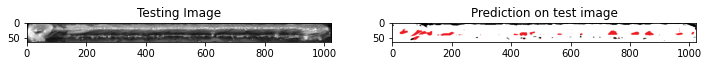

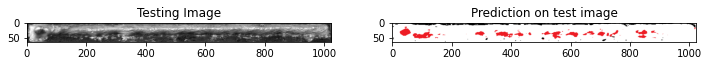

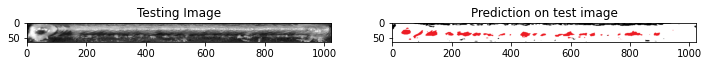

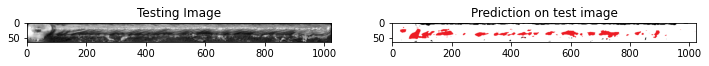

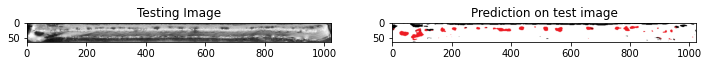

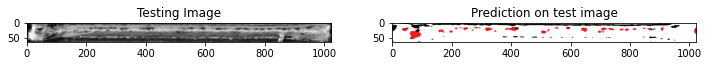

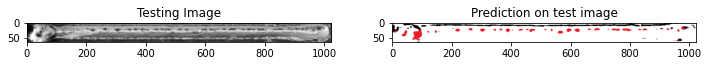

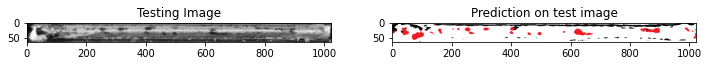

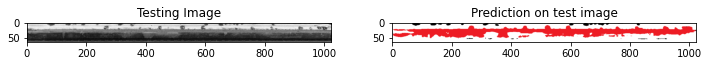

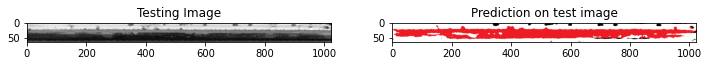

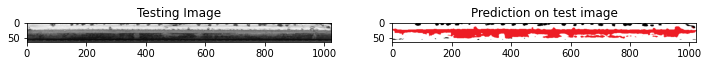

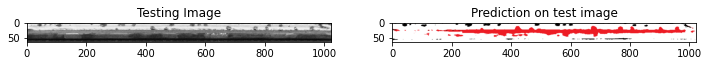

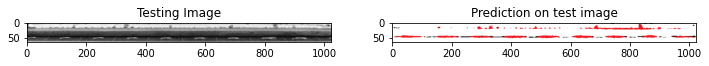

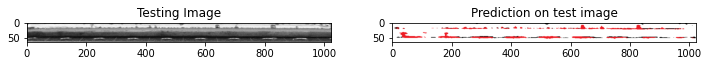

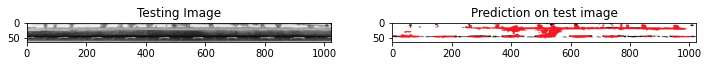

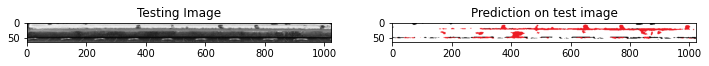

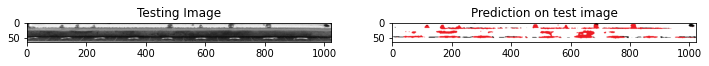

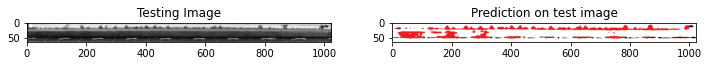

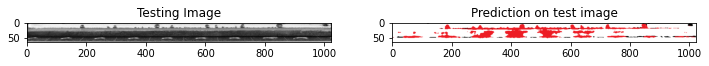

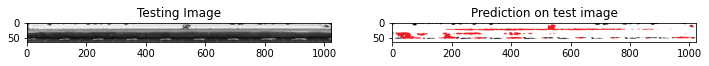

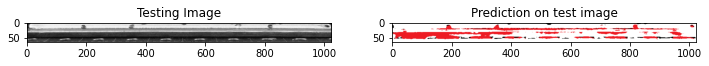

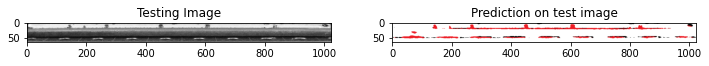

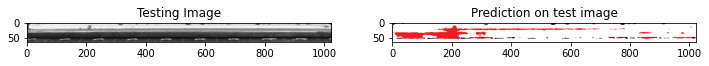

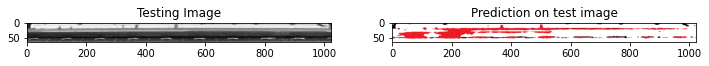

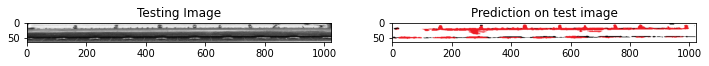

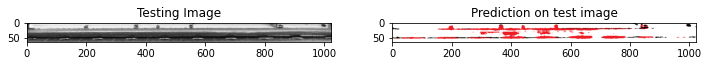

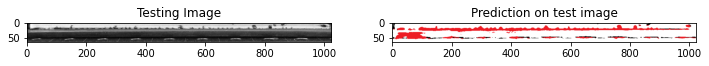

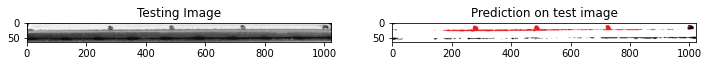

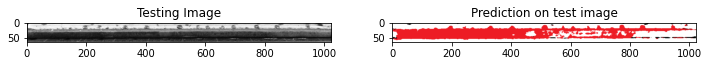

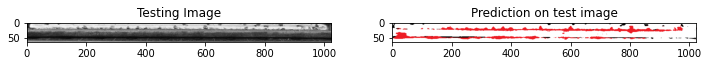

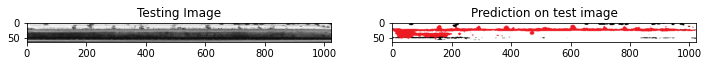

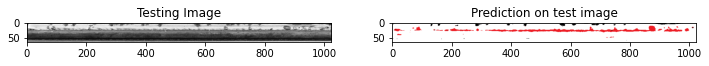

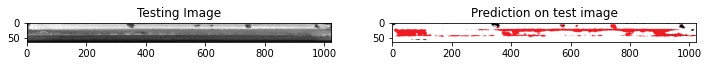

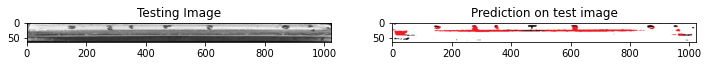

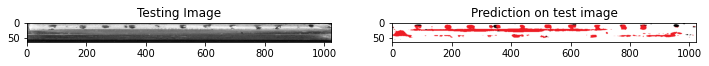

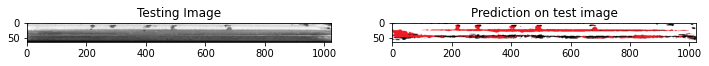

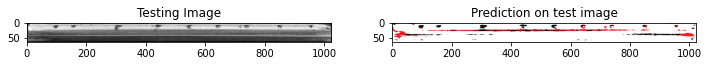

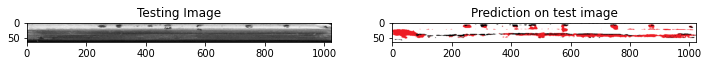

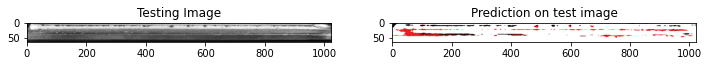

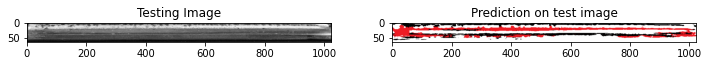

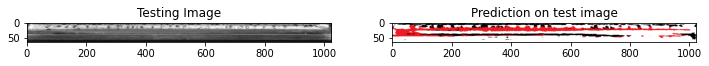

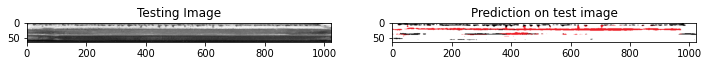

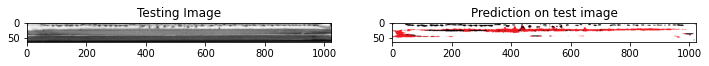

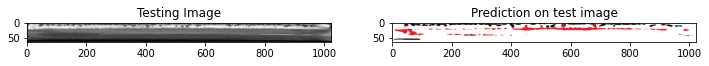

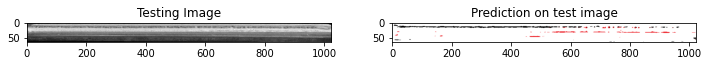

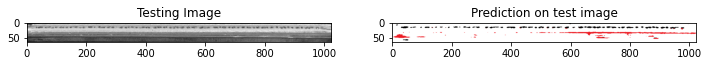

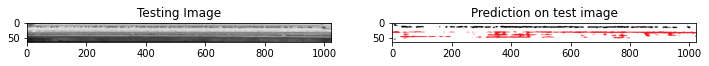

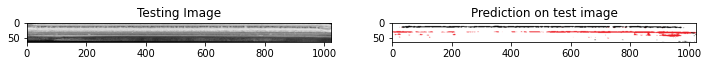

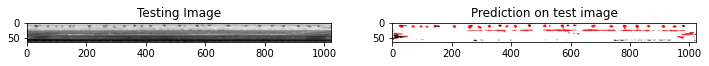

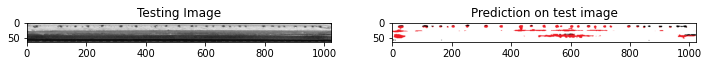

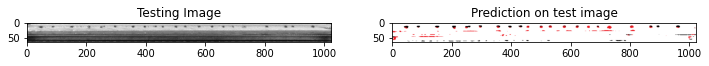

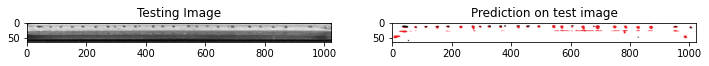

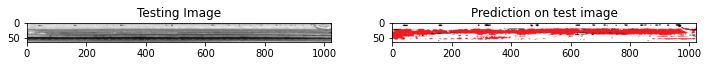

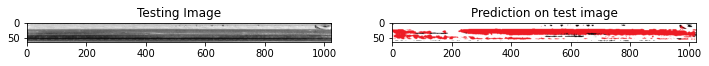

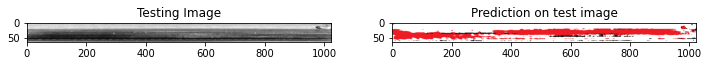

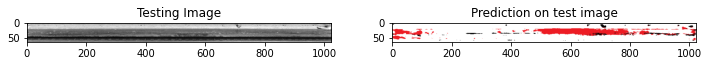

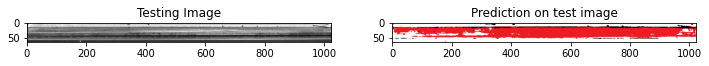

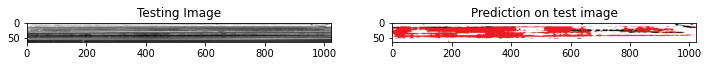

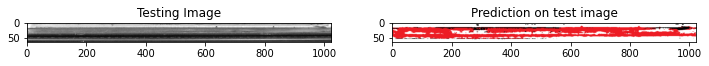

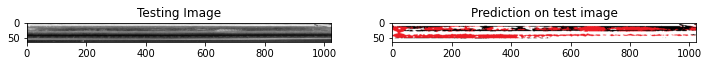

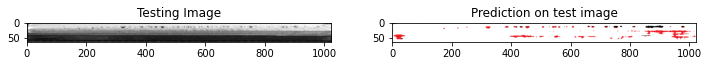

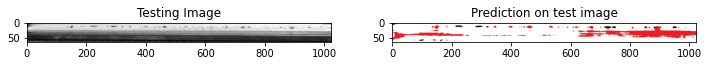

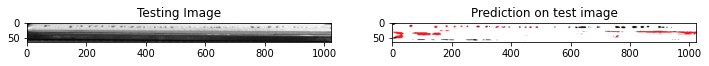

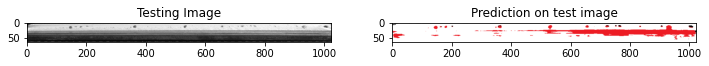

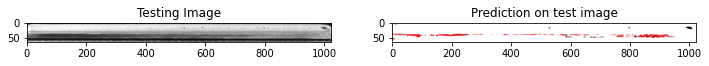

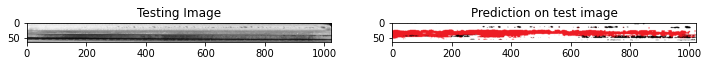

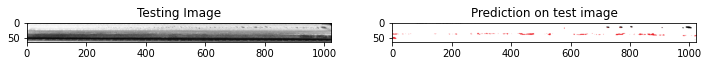

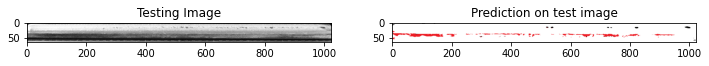

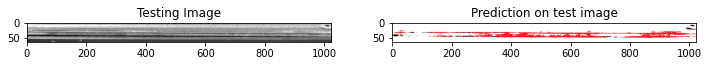

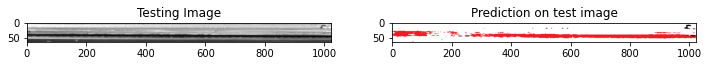

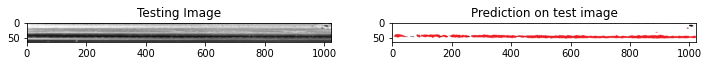

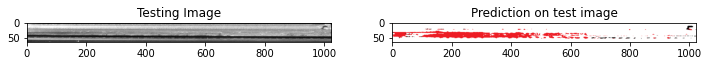

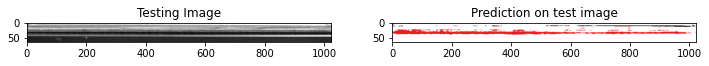

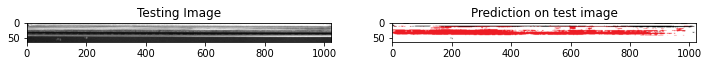

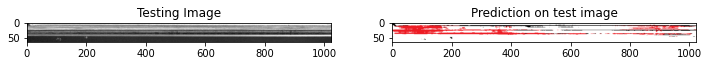

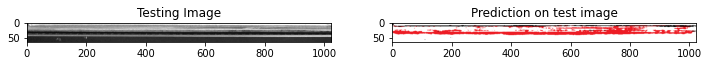

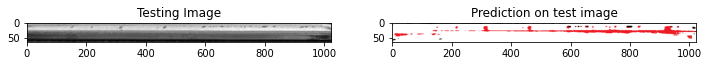

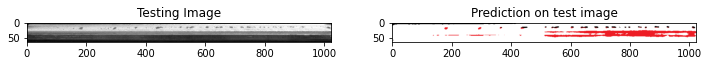

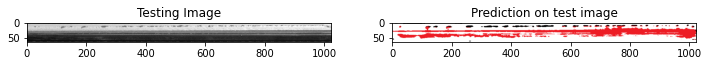

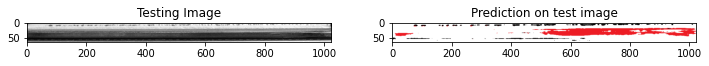

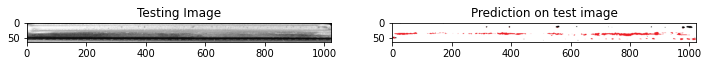

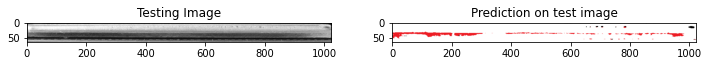

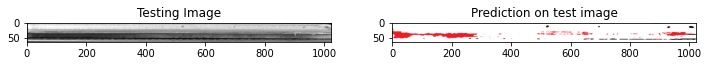

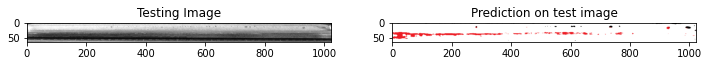

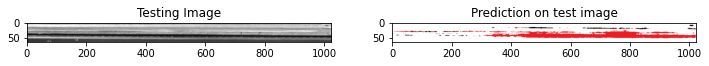

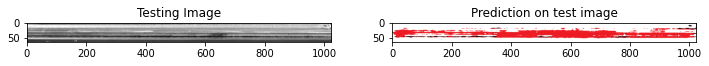

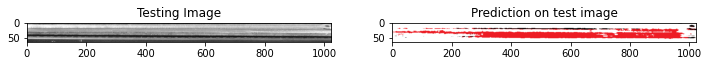

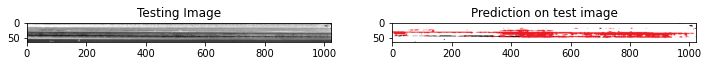

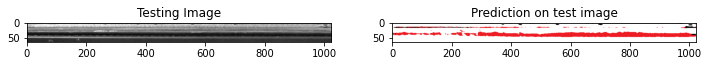

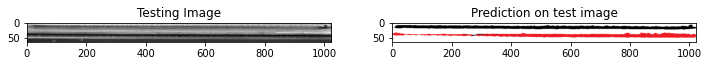

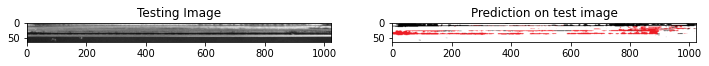

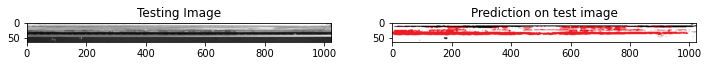

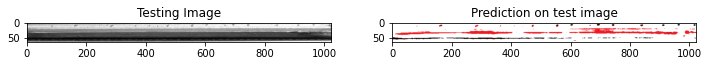

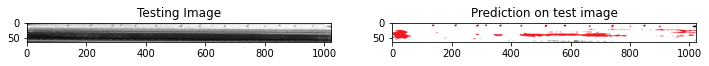

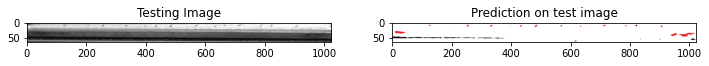

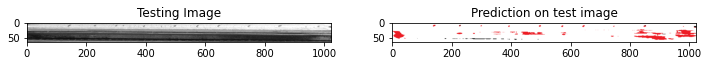

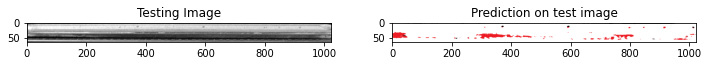

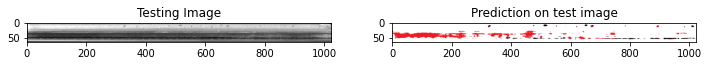

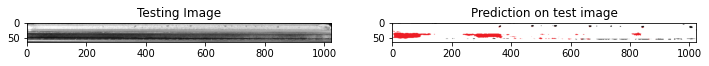

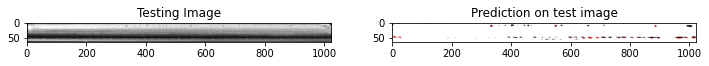

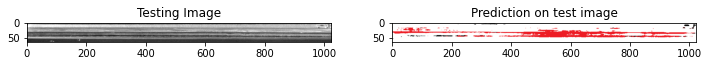

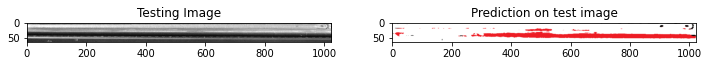

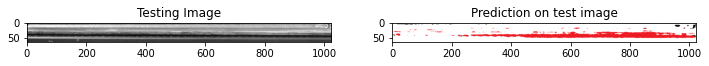

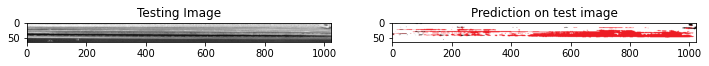

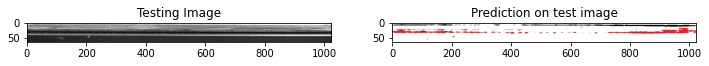

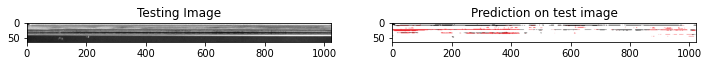

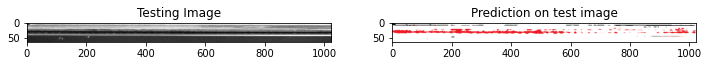

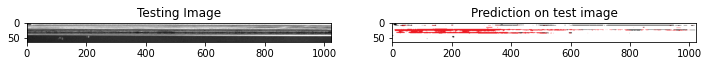

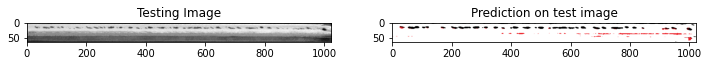

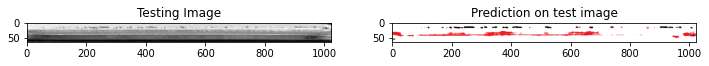

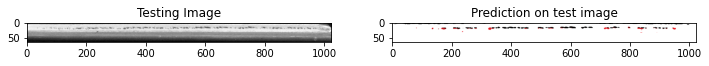

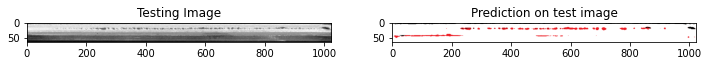

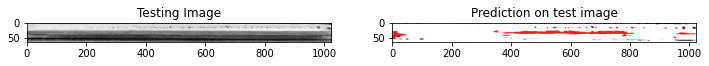

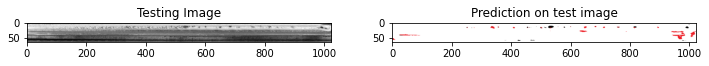

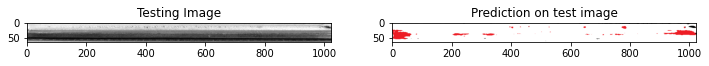

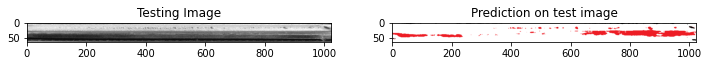

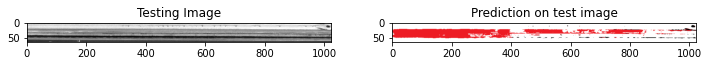

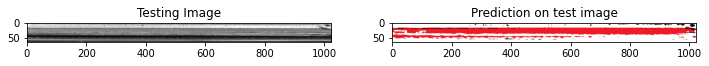

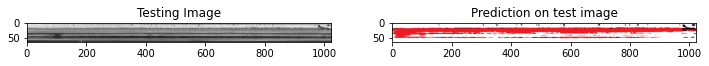

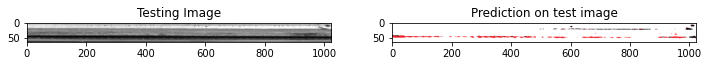

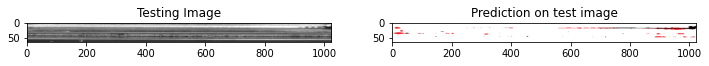

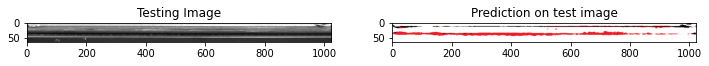

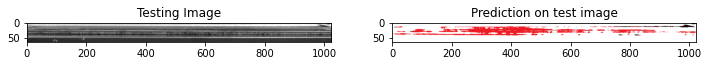

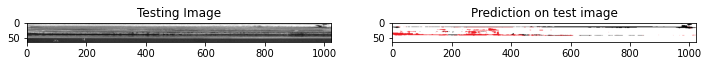

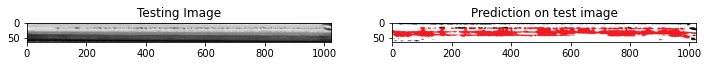

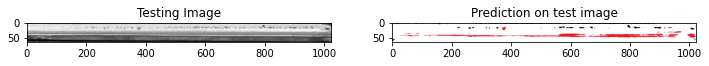

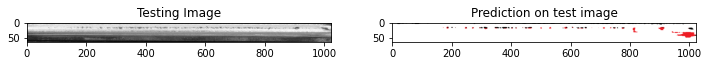

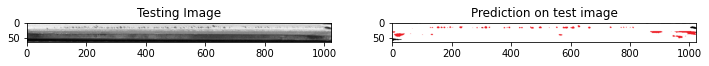

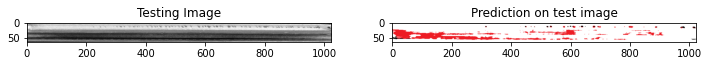

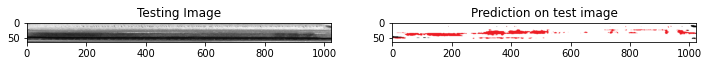

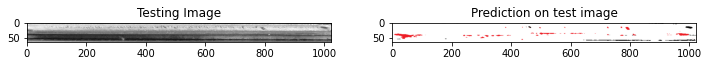

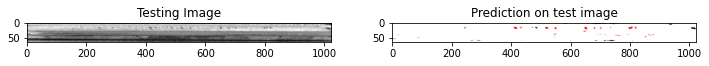

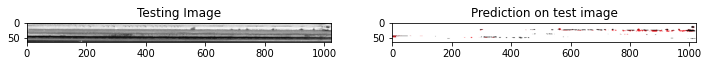

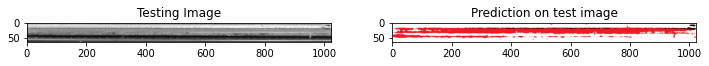

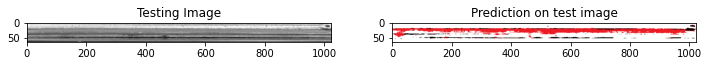

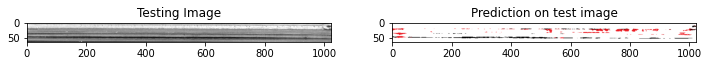

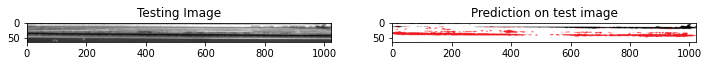

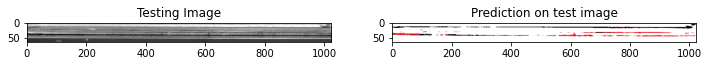

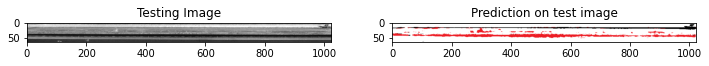

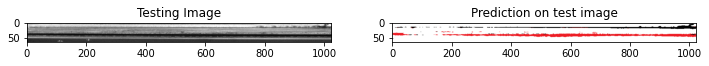

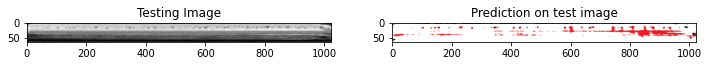

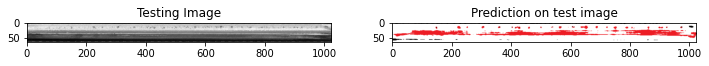

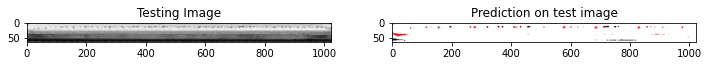

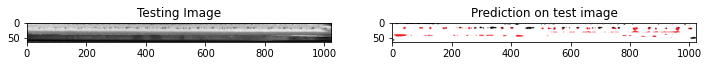

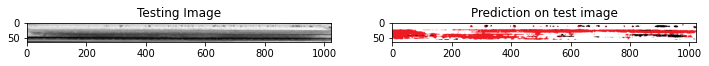

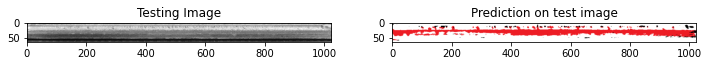

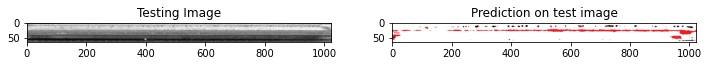

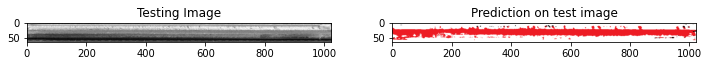

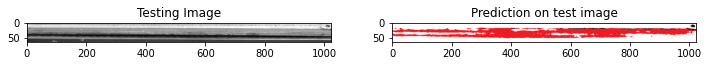

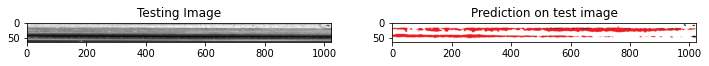

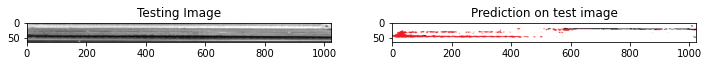

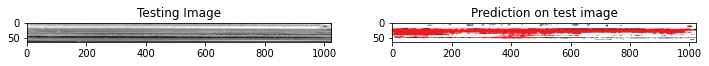

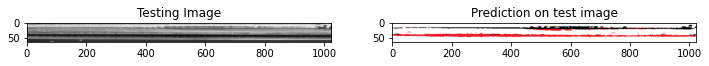

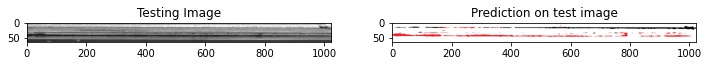

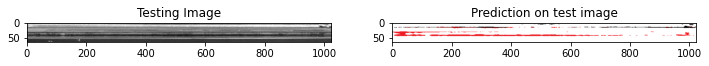

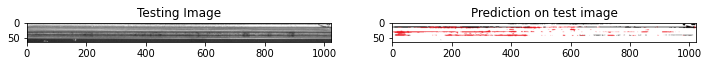

In [ ]:
import os
import glob
import cv2
from matplotlib import pyplot as plt

#for list of image names
imgname=os.listdir("/content/drive/MyDrive/Projects/Lincoln_unet/input3/cropped")
for i,name in enumerate(imgname):
  imgname[i]=name.split('.')[0]
imgname=sorted(imgname)

BGR_classes = {'a' : [ 0, 0, 0],
                'b' : [255,  255, 255],
                'c' : [36, 28, 237]} # in RGB #237,28,36

bin_classes = ['a', 'b', 'c']

imgs=glob.glob('/content/drive/MyDrive/Projects/Lincoln_unet/input3/cropped/*.jpg')
imgs.sort()

ds = tf_dataset(imgs, imgs, batch=1)
n = 0
for x, y in ds:
  #print(x.shape, y.shape) ## (8, 256, 256, 3), (8, 256, 256, 3)
  name=imgname[n]

  y_pred=model.predict(x)
  #print(y_pred.shape)
  y_pred=np.argmax(y_pred,axis=3)[0,:,:]



  plt.figure(figsize=(12, 8))
  plt.subplot(121)
  plt.title('Testing Image')
  plt.imshow(x[0,:,:,0], cmap='gray') # Works
  # #plt.imshow(cv2.cvtColor(x[:,:,0].astype(np.uint8),cv2.COLOR_BGR2RGB))


  plt.subplot(122)
  plt.title('Prediction on test image')
  se = set({})
  im3 = []
  for i in y_pred : 
    row = []
    for k in i :
        row.append(BGR_classes[bin_classes[k]])
    im3.append(row)
  im3_np=np.array(im3)
  final=cv2.cvtColor(im3_np.astype(np.uint8),cv2.COLOR_BGR2RGB)
  plt.imshow(final)


  cv2.imwrite(f"/content/drive/MyDrive/Projects/Lincoln_unet/input3/tensorflow_res2/{name}.png",im3_np)
  n=n+1
  #print(name)
  #plt.imshow(y_pred, cmap='jet')
  #break

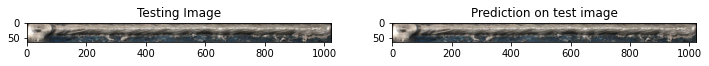

In [ ]:
import os
import glob
import cv2
from matplotlib import pyplot as plt

BGR_classes = {'a' : [ 0, 0, 0],
                'b' : [255,  255, 255],
                'c' : [36, 28, 237]} # in RGB #237,28,36

bin_classes = ['a', 'b', 'c']

imgs=glob.glob('/content/drive/MyDrive/Projects/Lincoln_unet/input3/cropped/*.jpg')
for x in imgs:
  plt.figure(figsize=(12, 8))
  
  plt.subplot(121)
  plt.title('Testing Image')
  ## Read image
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (W, H))
  #x = x / 255.0
  x = x.astype(np.float32)
  plt.imshow(x.astype(np.uint8))
  #plt.imshow(cv2.cvtColor(x.astype(np.uint8),cv2.COLOR_BGR2RGB))

  plt.subplot(122)
  plt.title('Prediction on test image')
  plt.imshow(x.astype(np.uint8))

  break


#ds = tf_dataset(test_x, test_y, batch=1)

6
6
(1, 64, 1024, 3) (1, 64, 1024, 3)
(1, 64, 1024, 3)


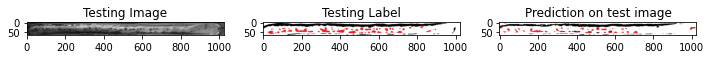

In [ ]:
from matplotlib import pyplot as plt
#y_pred=model.predict(test_x)

BGR_classes = {'a' : [ 0, 0, 0],
                'b' : [255,  255, 255],
                'c' : [36, 28, 237]} # in RGB #237,28,36

bin_classes = ['a', 'b', 'c']


ds = tf_dataset(test_x, test_y, batch=1)
print(len(test_x))
print(len(test_y))
for x, y in ds:
  print(x.shape, y.shape) ## (8, 256, 256, 3), (8, 256, 256, 3)

  y_pred=model.predict(x)
  print(y_pred.shape)
  y_pred=np.argmax(y_pred,axis=3)[0,:,:]



  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(x[0,:,:,0], cmap='gray') # Works
  #plt.imshow(cv2.cvtColor(x[:,:,0].astype(np.uint8),cv2.COLOR_BGR2RGB))


  plt.subplot(232)
  plt.title('Testing Label')
  ys=np.argmax(y,axis=3)[0,:,:]
  se = set({})
  im1 = []
  for i in ys : 
    row = []
    for k in i :
        row.append(BGR_classes[bin_classes[k]])
    im1.append(row)
  im1_np=np.array(im1)
  plt.imshow(cv2.cvtColor(im1_np.astype(np.uint8),cv2.COLOR_BGR2RGB))
  #plt.imshow(ys, cmap='jet')


  plt.subplot(233)
  plt.title('Prediction on test image')
  se = set({})
  im3 = []
  for i in y_pred : 
    row = []
    for k in i :
        row.append(BGR_classes[bin_classes[k]])
    im3.append(row)
  im3_np=np.array(im3)
  plt.imshow(cv2.cvtColor(im3_np.astype(np.uint8),cv2.COLOR_BGR2RGB))

  
  #plt.imshow(y_pred, cmap='jet')
  break

6
6
(1, 64, 1024, 3) (1, 64, 1024, 3)
(1, 64, 1024, 3)


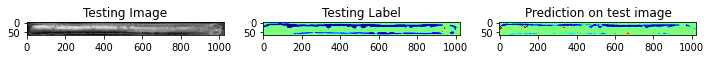

In [ ]:
from matplotlib import pyplot as plt
#y_pred=model.predict(test_x)

BGR_classes = {'a' : [ 0, 0, 0],
                'b' : [255,  255, 255],
                'c' : [36, 28, 237]} # in RGB #237,28,36

bin_classes = ['a', 'b', 'c']


ds = tf_dataset(test_x, test_y, batch=1)
print(len(test_x))
print(len(test_y))
for x, y in ds:
    print(x.shape, y.shape) ## (8, 256, 256, 3), (8, 256, 256, 3)

    y_pred=model.predict(x)
    print(y_pred.shape)
    y_pred=np.argmax(y_pred,axis=3)[0,:,:]



    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(x[0,:,:,0], cmap='gray') # Works
    #plt.imshow(cv2.cvtColor(x[:,:,0].astype(np.uint8),cv2.COLOR_BGR2RGB))
    plt.subplot(232)
    plt.title('Testing Label')
    ys=np.argmax(y,axis=3)[0,:,:]
    plt.imshow(ys, cmap='jet')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(y_pred, cmap='jet')
    break

(1, 64, 1024, 3) (1, 64, 1024, 3)
(1, 64, 1024, 3)


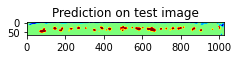

In [ ]:
from matplotlib import pyplot as plt
#y_pred=model.predict(test_x)


ds = tf_dataset(test_x, test_y, batch=1)
for x, y in ds:
    print(x.shape, y.shape) ## (8, 256, 256, 3), (8, 256, 256, 3)
    y_pred=model.predict(x)
    print(y_pred.shape)
    y_pred=np.argmax(y_pred,axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(y_pred, cmap='jet')
    break

Dataset: Train: 52 - Valid: 6 - Test: 6


  0%|          | 0/6 [00:00<?, ?it/s]

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [  0   0   0]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]

 ...

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 85  85  85]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [ 85  85  85]]

 [[170 170 170]
  [170 170 170]
  [170 170 170]
  ...
  [ 85  85  85]
  [170 170 170]
  [ 85  85  85]]]


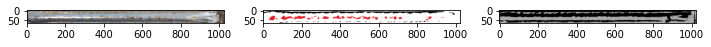

 17%|█▋        | 1/6 [00:00<00:04,  1.17it/s]

(64, 1024, 3) (64, 10, 3) (64, 1024, 3) (64, 10, 3) (64, 1024, 3)
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [170 170 170]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 85  85  85]
  [170 170 170]
  [  0   0   0]]]


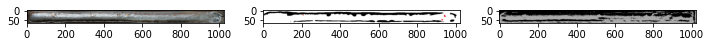

 33%|███▎      | 2/6 [00:01<00:02,  1.55it/s]

(64, 1024, 3) (64, 10, 3) (64, 1024, 3) (64, 10, 3) (64, 1024, 3)
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [170 170 170]
  [  0   0   0]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [  0   0   0]
  [170 170 170]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [170 170 170]
  [170 170 170]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]]


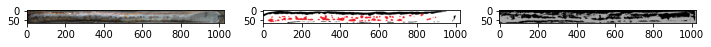

 50%|█████     | 3/6 [00:01<00:01,  1.77it/s]

(64, 1024, 3) (64, 10, 3) (64, 1024, 3) (64, 10, 3) (64, 1024, 3)
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [  0   0   0]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [  0   0   0]
  [170 170 170]]

 ...

 [[  0   0   0]
  [170 170 170]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 85  85  85]]

 [[  0   0   0]
  [170 170 170]
  [  0   0   0]
  ...
  [170 170 170]
  [170 170 170]
  [ 85  85  85]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [ 85  85  85]
  [ 85  85  85]
  [ 85  85  85]]]


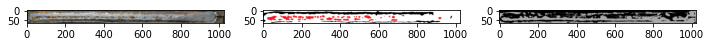

 67%|██████▋   | 4/6 [00:02<00:01,  1.95it/s]

(64, 1024, 3) (64, 10, 3) (64, 1024, 3) (64, 10, 3) (64, 1024, 3)
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [170 170 170]
  [  0   0   0]
  [170 170 170]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]

 ...

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [  0   0   0]
  ...
  [170 170 170]
  [170 170 170]
  [  0   0   0]]

 [[170 170 170]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [ 85  85  85]]]


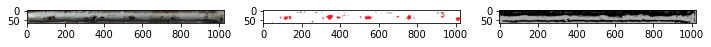

 83%|████████▎ | 5/6 [00:02<00:00,  1.68it/s]

(64, 1024, 3) (64, 10, 3) (64, 1024, 3) (64, 10, 3) (64, 1024, 3)
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [170 170 170]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [170 170 170]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [  0   0   0]
  [170 170 170]
  [ 85  85  85]]

 ...

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [170 170 170]
  [170 170 170]
  ...
  [170 170 170]
  [170 170 170]
  [  0   0   0]]

 [[170 170 170]
  [170 170 170]
  [170 170 170]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 85  85  85]]]


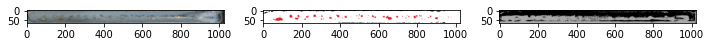

100%|██████████| 6/6 [00:03<00:00,  1.73it/s]

(64, 1024, 3) (64, 10, 3) (64, 1024, 3) (64, 10, 3) (64, 1024, 3)


In [ ]:

import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

H = 64
W = 1024
num_classes = 3

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Dataset """
    path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")


    """ Model """
    model = tf.keras.models.load_model("model.h5")

    """ Saving the masks """
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        
        name = x.split("/")[-1]

        plt.figure(figsize=(12,12))
        plt.subplot(1,3,1)
        
        ## Read image
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (W, H))
        #x = x / 255.0
        x = x.astype(np.float32)
        plt.imshow(cv2.cvtColor(x.astype(np.uint8),cv2.COLOR_BGR2RGB))

        plt.subplot(1,3,2)

        ## Read mask
        y = cv2.imread(y, cv2.IMREAD_COLOR)#cv2.IMREAD_GRAYSCALE
        y = cv2.resize(y, (W, H))   ## (256, 256)
        #y = y - 1
        #y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
        #y = y * (255/num_classes)
        y = y.astype(np.int32)
        plt.imshow(cv2.cvtColor(y.astype(np.uint8),cv2.COLOR_BGR2RGB))

        # y = cv2.imread(y)
        # y = cv2.resize(y, (W, H))
        # y = y - 1
        # y = np.expand_dims(y, axis=-1)
        # y = y * (255/num_classes)
        # y = y.astype(np.int32)
        # y = np.concatenate([y, y, y], axis=2)

        plt.subplot(1,3,3)

        ## Prediction
        p = model.predict(np.expand_dims(x, axis=0))[0]
        #print(p)
        p = np.argmax(p, axis=-1)
        p = np.expand_dims(p, axis=-1)
        p = p * (255/num_classes)
        p = p.astype(np.int32)
        p = np.concatenate([p, p, p], axis=2)
        print(p)
        plt.imshow(p)#cv2.cvtColor(p.astype(np.uint8),cv2.COLOR_BGR2RGB))
        plt.show()
        
        x = x * 255.0
        x = x.astype(np.int32)

        h, w, _ = x.shape
        line = np.ones((h, 10, 3)) * 255

        print(x.shape, line.shape, y.shape, line.shape, p.shape)

        final_image = np.concatenate([x, line, y, line, p], axis=1)
        #cv2.imwrite(f"/content/drive/MyDrive/Projects/Lincoln_unet/input1/results/x{name}", final_image)